In [1]:
cd "/home/hqvo2/Projects/MultiMEDal_multimodal_medical/libs/CLIP"

/home/hqvo2/Projects/MultiMEDal_multimodal_medical/libs/CLIP


In [2]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

/home/hqvo2/miniconda3/envs/clip_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    
print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.9927937  0.00421067 0.00299573]]


In [4]:
from MultiMEDal_multimodal_medical.src.datasets.CBIS_DDSM import CBIS_DDSM_dataset
from MultiMEDal_multimodal_medical.src.datasets.data_transform import build_transform_dict
from MultiMEDal_multimodal_medical.src.plotting.plot_imgs import matplotlib_imshow

In [5]:
transform = build_transform_dict()

In [6]:
cbis_ddsm_root = "/home/hqvo2/Projects/MultiMEDal_multimodal_medical/data/CBIS-DDSM/original"
datasets_dict = {
    'train': CBIS_DDSM_dataset(cbis_ddsm_root, 'train', '2classes', birads=[3], 
                                abnormality=['mass', 'calcification'], transform=transform['train']),
    'val': CBIS_DDSM_dataset(cbis_ddsm_root, 'test', '2classes', birads=[3], 
                                abnormality=['mass', 'calcification'], transform=transform['val']),
    'test': CBIS_DDSM_dataset(cbis_ddsm_root, 'test', '2classes', birads=[3], 
                                abnormality=['mass', 'calcification'], transform=transform['test'])
}

# Samples: (368, 54)
# Samples: (109, 54)
# Samples: (109, 54)


In [7]:
lesion_feats_label = datasets_dict['train'].get_lesion_feats_label()

In [79]:
image, label, lesion_feats, image_path = datasets_dict['train'][70]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


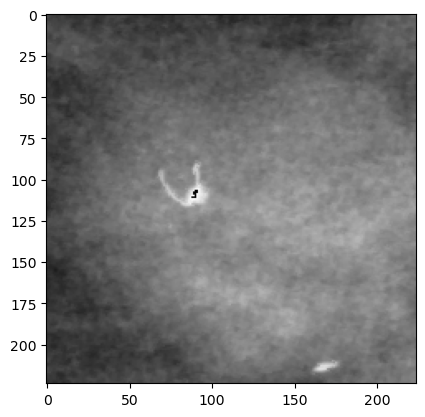

In [80]:
matplotlib_imshow(image)

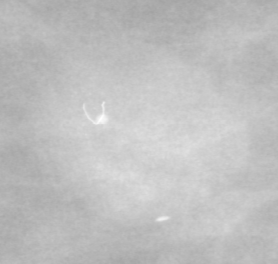

In [83]:
from IPython.display import Image
Image(filename=image_path) 

In [81]:
def generate_lesion_description(lesion_feats, lesion_feats_label):
    active_labels = lesion_feats_label[lesion_feats == 1]

    abnormality = 'mass' if lesion_feats[0] == 1 else 'calcification'

    feats = ''

    for label in active_labels:
        if label == 'abnormality type.1':
            continue

        feats += label.split('-')[1].lower()
        feats += ' '

    return f"a {feats}{abnormality}"

In [82]:
print(generate_lesion_description(lesion_feats, lesion_feats_label))

a oval circumscribed mass


In [63]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
# image, class_id = cifar100[3637]

# image, label, lesion_feats, image_path = datasets_dict['val'][0]
image_input = image.unsqueeze(0).to(device)
# image_input = preprocess(image).unsqueeze(0).to(device)

# text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)


gt_text = generate_lesion_description(lesion_feats, lesion_feats_label)
# text_cands = [gt_text, 'an irregular mass with spiculated margin', 'a linear amorphous calcification']
text_cands = ['lobulated', 'round', 'oval', 'irregular']
text_inputs = torch.cat([clip.tokenize(text) for text in text_cands]).to(device)
print(text_inputs.shape)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(4)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{text_cands[index]:>16s}: {100 * value.item():.2f}%")

Files already downloaded and verified
torch.Size([4, 77])

Top predictions:

       irregular: 49.02%
       lobulated: 20.33%
           round: 16.16%
            oval: 14.49%
